In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
import heapq as hq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# --- PyTorch
import torch
from torch_geometric.data import Batch
import lightning as L
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.models import Label
from bokeh.layouts import row
output_notebook()
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
# --- Modules from local files
from GNN import QM9_GNN
from utils.model import get_spec_prediction
from utils.utils import bokeh_spectra, calculate_rse, bokeh_hist

Loading BokehJS ...

In [2]:
# --- Define GNN properties
num_tasks = 300
num_layers = 5
in_channels = [9, 60, 60, 60, 60]
out_channels = [60, 60, 60, 60, 300]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.0
graph_pooling = 'mean'

In [3]:
model = QM9_GNN(
    num_tasks,
    num_layers,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)

In [4]:
checkpoint = './ML_models/lightning_logs/version_2/checkpoints/epoch=299-step=679500.ckpt'
hparam = './ML_models/lightning_logs/version_2/hparams.yaml'

model = QM9_GNN.load_from_checkpoint(checkpoint, hparams_file=hparam)

In [5]:
model.eval()

QM9_GNN(
  (convs): ModuleList(
    (0): GCNConv(9, 60)
    (1-3): 3 x GCNConv(60, 60)
    (4): GCNConv(60, 300)
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (graph_pred_linear): Linear(in_features=300, out_features=300, bias=True)
)

In [7]:
test_dataset = torch.load("./processed/test_version2_nocharge_hot_num.pt")
test_dataset

/tmp/ipykernel_47606/1738915680.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load("./processed/test_version2_nocharge_hot_num.pt")


XASDataset(6292)

In [9]:
test_dataset[0]

Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 4], spectrum=[300], idx=[1], smiles='N=C1C[C@@H](C=O)C(=O)N1')

In [9]:
device = "cpu"
model = model.to(device)

In [15]:
flat = torch.flatten(test)

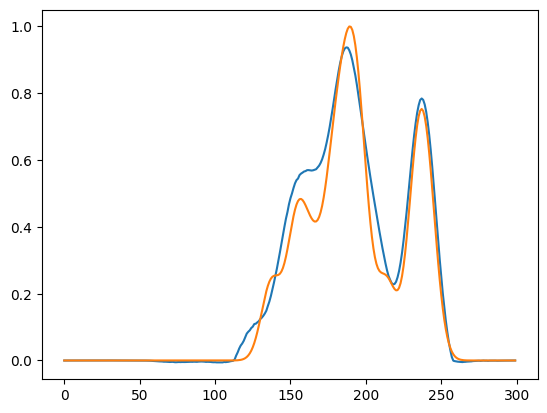

In [17]:
plt.plot(flat)
plt.plot(test_dataset[0].spectrum)
plt.show()

In [ ]:
pred = {}
true = {}

for index in range(len(test_dataset)):
    pred

In [14]:
# --- Create empty dictionary to contain spectra
pred = {}
tru = {}

# --- Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    pred[index], tru[index] = get_spec_prediction(model, index, test_dataset, device)

# --- Parse spectra into dictionary
model_dict = [pred, tru]

# # --- Save prediction results to file
# with open("ML_models/results/" + model_name, "wb") as file:
#     pkl.dump(model_dict, file)
    
# --- Get 
predict = model_dict[0]
true = model_dict[1]

In [18]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    # rse_temp = calculate_rse(true[x], predict[x])
    # rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

ave_wasser = sum(wasser) / len(wasser)
ave_spear = sum(spear) / len(spear)
ave_mse = sum(mse) / len(mse)
# ave_rse = sum(rse) / len(rse)

print(f"Average Wasserstein distance = {ave_wasser}")
print(f'Average spearman correlation coefficient = {ave_spear}')
print(f"Average MSE = {ave_mse}")
# print(f'Average RSE = {ave_rse}')

Average Wasserstein distance = 0.02855720125688561
Average spearman correlation coefficient = 0.73877764194989
Average MSE = 0.0058188787661492825


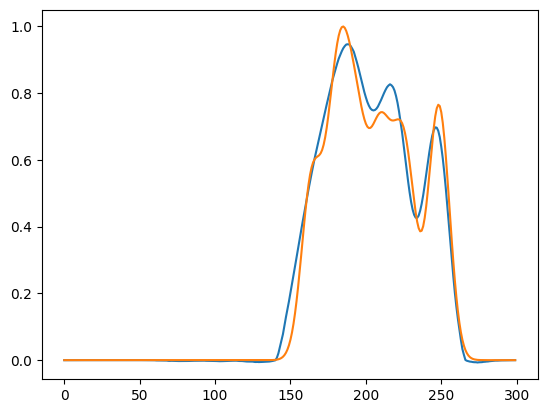

In [23]:
plt.plot(predict[2])
plt.plot(true[2])
plt.show()

In [20]:
rank_rse = hq.nsmallest(6292, mse)

rank_graph = []

for x in range(6292):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

ValueError: np.float32(0.00031542598) is not in list

In [23]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[6000]], true[rank_graph[6000]])
p = row(p1, p2, p3)
show(p)